In [1]:
import sys
sys.version

'3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]'

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import time
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg as la
import scipy.sparse.linalg as sla
# sns.set()
# plt.style.use("dark_background")

#### Creating Lissajous Curves.
- Function to create Lissajous Curves.
    - https://en.wikipedia.org/wiki/Lissajous_curve

In [4]:
def sampleLC(a,b,c,d,n):
    """
    The functions allows sampling from a Lissajous Curve based on the given parameters.
    
    Parameters:
    
    a,b,c,d are the parameters to get the shape that we want.
    n (sampling points): How many points are needed for the sampling.
    
    Returns:
    X: (n,2) matrix having the sampled points.
    """
    X = np.zeros((n,2))
    
    for i in range(n):
        x = np.random.random()*2*np.pi;
        X[i,:] = np.sin(a*x+b), np.sin(c*x+d)
    return X

## Lissajous Forms.

In [5]:
def draw_liss(data):
    plt.figure(figsize=(5,5))
    plt.scatter(data[:,0],data[:,1],color="red",s=4)
    return plt.show()

##### Circle.

In [6]:
circle = sampleLC(1,0,1,-np.pi/2,1000)

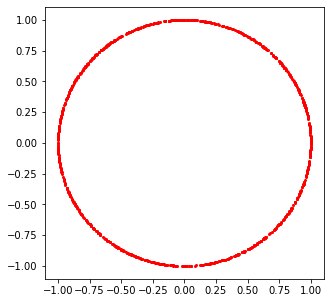

In [7]:
draw_liss(circle)

##### 8 Shaped Curve.

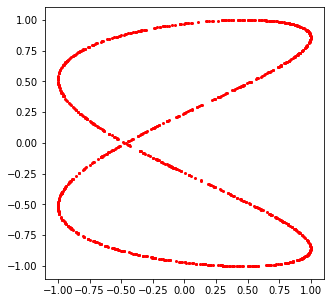

In [8]:
eight_shape = sampleLC(2,0.11,1,0.3,1000)
draw_liss(eight_shape)

##### Advanced Shape.

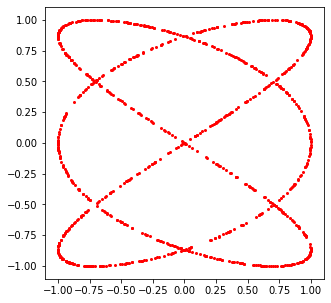

In [9]:
advanced_shape = sampleLC(3,np.pi/2,2,0,1000)
draw_liss(advanced_shape)

## Learning set implementation Algorithm.

#### Grid.
- Creates a grid given the shape of the grid.
- New version optimized, using meshgrid and reshaping (instead of looping).

In [10]:
# def Grid_original(a,b):
#     Y = np.zeros((np.size(a)*np.size(b),2))
#     k = 0
#     for i in a:
#         for j in b:
#             Y[k,:] = i,j 
#             k = k + 1
#     return Y

In [11]:
# turns two arrays into a grid / mesh grid.
# def Grid2(a,b):
#     Y = np.zeros((np.size(a)*np.size(b),2))
#     for i in range(len(a)):
#             Y[len(a)*i:len(a)*(i+1),0] = np.array([a[i]]*len(a))
#             Y[len(a)*i:len(a)*(i+1),1] = b
#     return Y

In [12]:
def Grid(a,b):
    xx,yy = np.meshgrid(a,b)
    new_grid = np.concatenate([yy.reshape(-1,1),xx.reshape(-1,1)],axis=1)
    return new_grid

##### Kernels.

In [13]:
# abel = lambda x,y,t,p: np.exp(-np.abs(p) * np.linalg.norm(x-y))

In [14]:
abel_2 = lambda x,y,t,p: np.linalg.norm(x-y)

In [15]:
polynomial = lambda x,y,t,p : (x@y.T + t)**p

##### GRAMS.

- Gram_10 Optimization
    - The exponential part of the Laplacian is applied on all the function instead of per element.
        - `K = np.exp(-abs(p)*K)`
    - A block of values is now calculated and transformed instead of nested looping over values.
        - `K[i,:s] = np.linalg.norm(X[i,:]-Y,axis=1)`
    

In [16]:
def Gram_10(X,Y,function,t,p):
    n = X.shape[0]
    s = Y.shape[0]
    K = np.zeros((n,s))
    if function==abel_2:
        for i in range(n):
                K[i,:s] = np.linalg.norm(X[i,:]-Y,axis=1)
        K = np.exp(-abs(p)*K)
    else:
        K = polynomial(X,Y,t,p)
    return K

In [17]:
# def Gram_2(X,Y,function,t,p):
#     n = X.shape[0]
#     s = Y.shape[0]
#     K = np.zeros((n,s))
#     if function==abel_2:
#         for i in range(n):
#             for j in range(s):
#                 K[i,j] = np.linalg.norm(X[i,:]-Y[j,:])
#         K = np.exp(-abs(p)*K)
#     else:
#         K = polynomial(X,Y,t,p)
#     return K

In [18]:
# def Gram(X,Y,function,t,p):
#     n = X.shape[0]
#     s = Y.shape[0]
#     K = np.zeros((n,s))
#     if function==abel:
#         for i in range(n):
#             for j in range(s):
#                 K[i,j] = abel(X[i,:],Y[j,:],t,p)
#     else:
#         K = polynomial(X,Y,t,p)
#     return K

##### Diagonal Gram.
- Optimized for polynomial 
- Optimized for abel_2
- Free form for other functions.

In [19]:
def DGram(X,function,t,p):
    n = X.shape[0]
    arra = np.zeros((n,1))
    if function==polynomial:
        for i in range(n):
            arra[i,0] = function(X[i,:],X[i,:],t,p)
    else:
        arra[:,0] = 0
        return np.exp(-abs(p)*arra)
    return arra

##### LEARN AND TEST.
- double sum on `s` was removed, since `np.sum(K)` does the job similar to double sum in matlab.
- hardcutoff_2 implementation

In [20]:
# uses optimized hardcuttoff
def learnSet2(X,function,t,p,m):
    n = X.shape[0]
    
    H = np.eye(n) - np.ones((n,n))/n
    
    K = Gram_10(X,X,function,t,p)
    G = H @ hardcutoff_2(H@K@H/n,m) @ H / n
    
    mu = K @ np.ones((n,1))/n
    
    s = np.sum(K)/n**2
    
    return G,mu,s

In [21]:
# uses original hardcutoff
def learnSet(X,function,t,p,m):
    n = X.shape[0]
    
    H = np.eye(n) - np.ones((n,n))/n
    
    K = Gram_10(X,X,function,t,p)
    G = H @ hardcutoff(H@K@H/n,m) @ H / n
    
    mu = K @ np.ones((n,1))/n
    
    s = np.sum(K)/n**2
    
    return G,mu,s

In [22]:
def testSet(X,G,mu,s,function,t,c,Y):
    n = X.shape[0]
    p = Y.shape[0]
    start_time = time.time()
    W = Gram_10(Y,X,function,t,c)
    print(f"-----W-testSet {time.time()-start_time} seconds ------")
    Z = W - np.ones((p,1)) @ mu.T
    start_time = time.time()
    y = DGram(Y,function,t,c) + s - 2 * (W @ np.ones((n,1))) /n - np.sum((Z@G)*Z,axis=1).reshape(-1,1)
    print(f"-----y-testSet {time.time()-start_time} seconds ------")
    return y

##### HardCutOffs
- `sla.eigsh` was used instead of `np.linalg.eig` for better calculation of the eigenvalues and eigenvectors.

In [23]:
def hardcutoff_2(C,m):
    # extract first m eigenvectors and values ordered by "Largest Magnitude"
    D, V = sla.eigsh(C,k=m,which="LM")
    D = D.reshape(-1,1)
    n = np.size(D)
    K = np.zeros((n,n),complex)
    Z = np.true_divide(1,D)
    np.fill_diagonal(K,Z[:,0].tolist())
    Y = V @ K @ np.matrix(V).getH()
    return np.asarray(Y)

In [24]:
def hardcutoff(C,m):
    D, V = np.linalg.eig(C)
    V = V[:,:m]
    D = D[:m].reshape(-1,1)
    n = np.size(D)
    K = np.zeros((n,n),complex)
    Z = np.true_divide(1,D)
    np.fill_diagonal(K,Z[:,0].tolist())
    Y = V @ K @ np.matrix(V).getH()
    return np.asarray(Y)

# Testing the Algorithm.

In [25]:
plt.style.use("default")

In [26]:
def do_Kernel_support(n,m,function,tau,c,t=0):
    a = np.arange(-1.3,1.3,0.03)
    b = np.arange(-1.3,1.3,0.03)
    Y = Grid(a,b)
    
    X = sampleLC(2,0.11,1,0.3, n)*0.8;

    G, mu, s = learnSet(X,function,t, c, m);
    y = testSet(X, G, mu, s,function,t, c, Y);
    
    return X,y.astype(float).reshape(-np.size(a),np.size(b)).T

-----W-testSet 0.08441472053527832 seconds ------
-----y-testSet 0.034593820571899414 seconds ------
-----W-testSet 0.11469173431396484 seconds ------
-----y-testSet 0.013936519622802734 seconds ------
-----W-testSet 0.10072731971740723 seconds ------
-----y-testSet 0.02792501449584961 seconds ------
-----W-testSet 0.21439552307128906 seconds ------
-----y-testSet 0.19056487083435059 seconds ------


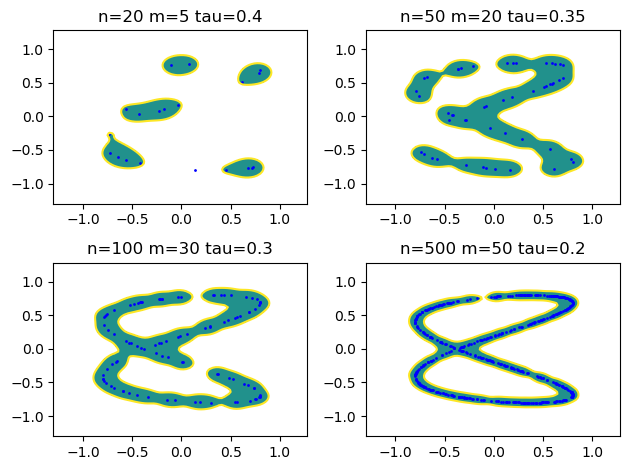

In [27]:
a = np.arange(-1.3,1.3,0.03)
b = np.arange(-1.3,1.3,0.03)
fig, ax = plt.subplots(2,2)
for axes,n,m,tau in zip(ax.flat,[20,50,100,500],[5,20,30,50],[0.4,0.35,0.3,0.2]):
    X,y_casted_real = do_Kernel_support(n,m,abel_2,tau,2)
    axes.title.set_text(f"n={n} m={m} tau={tau}")
    axes.contourf(a,b,y_casted_real,levels=[0,tau])
    axes.contour(a,b,y_casted_real,levels=[0,tau])
    axes.scatter(X[:,0],X[:,1],color="blue",s=1)
plt.tight_layout()
plt.show()

In [28]:
def do_Kernel_support_circle(n,m,function,c,t=0):
    a = np.arange(-1.3,1.3,0.03)
    b = np.arange(-1.3,1.3,0.03)
    Y = Grid(a,b)
    
    X = sampleLC(1,0,1,np.pi/2,n)*0.8;

    G, mu, s = learnSet(X,function,t, c, m);
    y = testSet(X, G, mu, s,function,t, c, Y);
    
    return X,y.astype(float).reshape(-np.size(a),np.size(b)).T

-----W-testSet 0.013963699340820312 seconds ------
-----y-testSet 0.06584978103637695 seconds ------
-----W-testSet 0.0010173320770263672 seconds ------
-----y-testSet 0.02790522575378418 seconds ------
-----W-testSet 0.0010237693786621094 seconds ------
-----y-testSet 0.023909568786621094 seconds ------
-----W-testSet 0.002038240432739258 seconds ------
-----y-testSet 0.026927709579467773 seconds ------


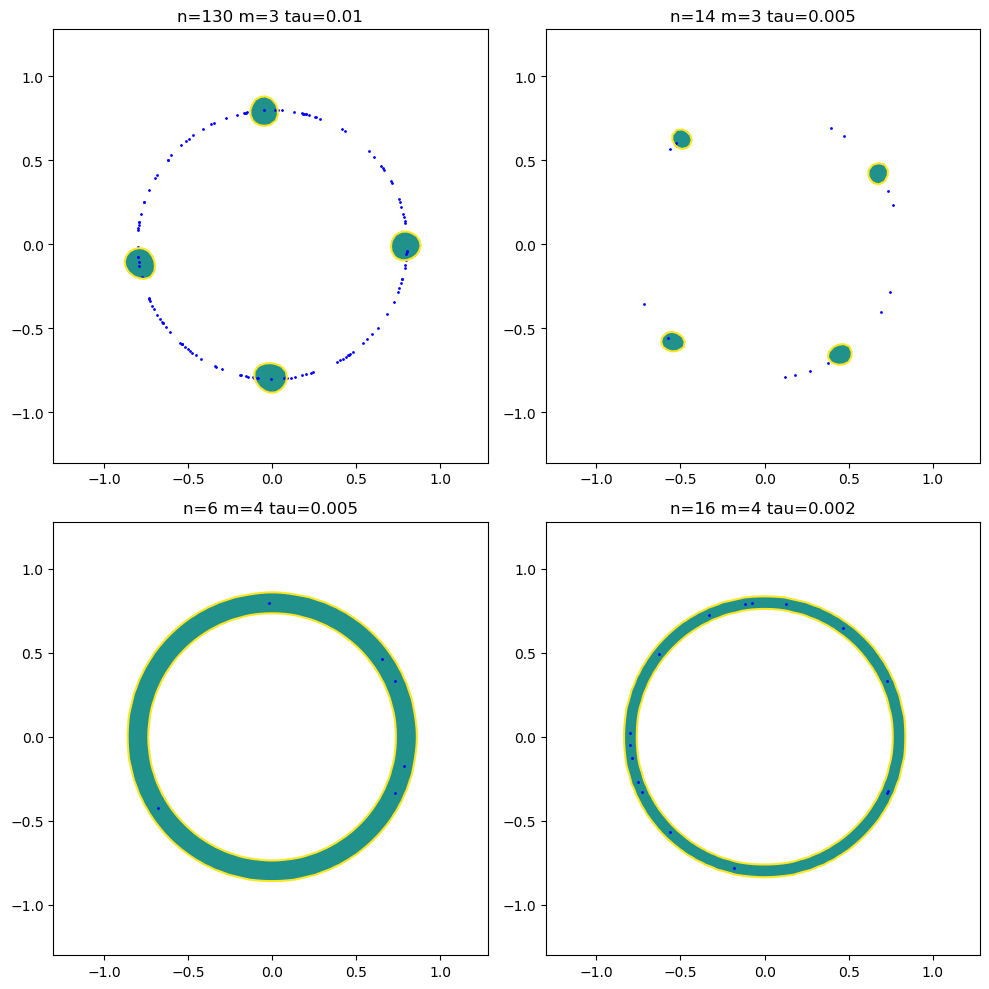

In [29]:
a = np.arange(-1.3,1.3,0.03)
b = np.arange(-1.3,1.3,0.03)
fig, ax = plt.subplots(2,2,figsize=(10,10))
for axes,n,m,tau in zip(ax.flat,[130,14,6,16],[3,3,4,4],[0.01,0.005,0.005,0.002]):
    X,y_casted_real = do_Kernel_support_circle(n,m,polynomial,2,1)
    axes.title.set_text(f"n={n} m={m} tau={tau}")
    axes.contourf(a,b,y_casted_real,levels=[0,tau])
    axes.contour(a,b,y_casted_real,levels=[0,tau])
    axes.scatter(X[:,0],X[:,1],color="blue",s=1)
plt.tight_layout()
plt.show()

## RESAMPLING.

In [30]:
plt.style.use("dark_background")

#### Circle Resample trial.

In [31]:
n_2 = 6
m_2 = 4
tau_2 = 0.002
t=1
c=2
function = polynomial
X = sampleLC(1,0,1,np.pi/2,n_2)*0.8;

a = np.arange(-1.3,1.3,0.03)
b = np.arange(-1.3,1.3,0.03)
Y = Grid(a,b)

G, mu, s = learnSet(X,function, t,c, m_2);
y = testSet(X, G, mu, s,function,t, c, Y);
y_casted_real_circle = y.astype(float).reshape(-np.size(a),np.size(b)).T

-----W-testSet 0.0009987354278564453 seconds ------
-----y-testSet 0.04288601875305176 seconds ------


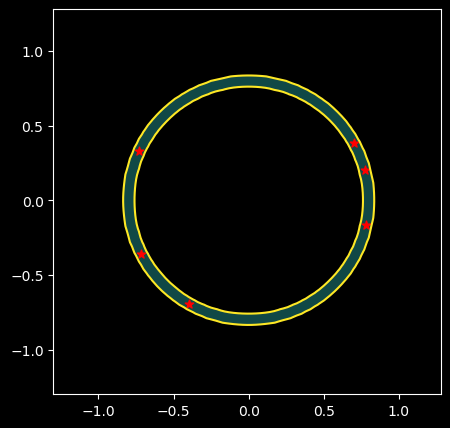

In [32]:
plt.figure(figsize=(5,5))
plt.contourf(a,b,y_casted_real_circle,levels=[0,tau_2],alpha=0.5)
plt.contour(a,b,y_casted_real_circle,levels=[0,tau_2])
plt.scatter(X[:,0],X[:,1],marker="*",color="red",s=40)
plt.show()

##### Using a uniform distribution to resample.
- Up to 1.5m points, the algorithm works fast.
- At 15m points it takes 40 seconds +.
- The drawing takes also a huge time.

-----W-testSet 0.01101064682006836 seconds ------
-----y-testSet 0.6220340728759766 seconds ------


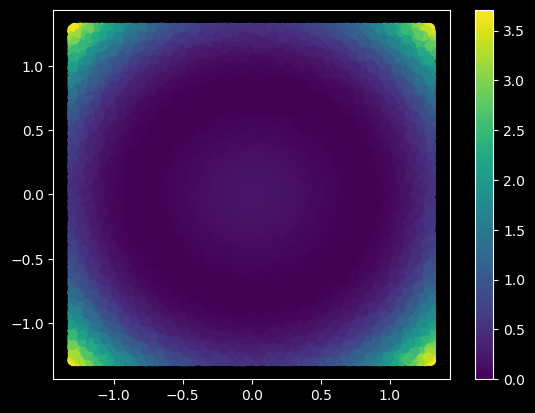

In [33]:
# sample X uniformly 
X_uniform_circle = np.random.uniform(-1.3,1.3,(150000,2))
# apply test on new data
y_new_circle = testSet(X,G, mu, s,function,t, c, X_uniform_circle).astype(float)
plt.scatter(X_uniform_circle[:,0],X_uniform_circle[:,1],c=y_new_circle.ravel())
plt.colorbar()
plt.show()

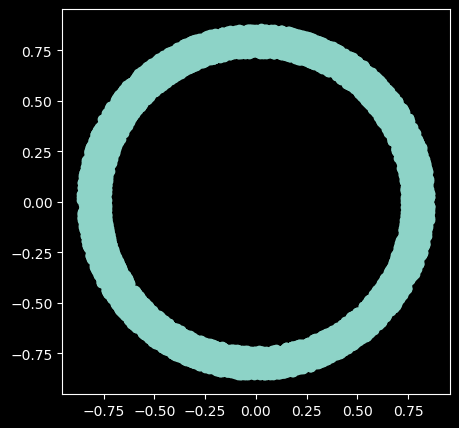

In [34]:
y_new_circle_series = pd.Series(y_new_circle.ravel())
indexes_tau2 = y_new_circle_series[y_new_circle_series<=0.005].index
plt.figure(figsize=(5,5))
plt.scatter(X_uniform_circle[indexes_tau2,0],X_uniform_circle[indexes_tau2,1])
plt.show()

#### 8 Shape sampling trial.

In [35]:
import time

In [36]:
## Testing using the hardcutoff_2 which contains *EIGSH* from scipy. 
n_8 = 500
m_8 = 50
tau_8 = 0.2
c=2
t=0
a = np.arange(-1.3,1.3,0.03)
b = np.arange(-1.3,1.3,0.03)
Y = Grid(a,b)

function = abel_2
X = sampleLC(2,0.11,1,0.3, n_8)*0.8;

# testing the time of the learning part
G, mu, s = learnSet2(X,function,t, c, m_8);

y_8shape = testSet(X, G, mu, s,function,t, c, Y);

y_casted_real_8shape = y_8shape.astype(float).reshape(-np.size(a),np.size(b)).T

-----W-testSet 0.28324246406555176 seconds ------
-----y-testSet 0.1874995231628418 seconds ------


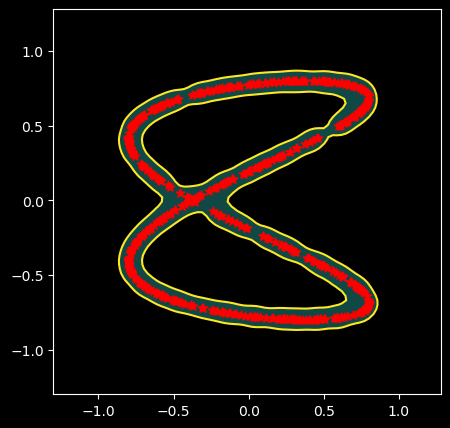

In [37]:
plt.figure(figsize=(5,5))
plt.contourf(a,b,y_casted_real_8shape,levels=[0,tau_8],alpha=0.5)
plt.contour(a,b,y_casted_real_8shape,levels=[0,tau_8])
plt.scatter(X[:,0],X[:,1],marker="*",color="red",s=40)
plt.show()

-----W-testSet 0.4717373847961426 seconds ------
-----y-testSet 0.3759951591491699 seconds ------


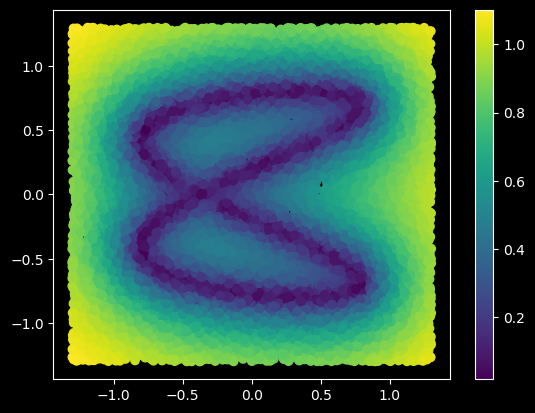

In [38]:
# sample X uniformly 
X_uniform_8shape = np.random.uniform(-1.3,1.3,(15000,2))
# apply test on new data
y_new_8shape = testSet(X,G, mu, s,function,t, c, X_uniform_8shape).astype(float)
plt.scatter(X_uniform_8shape[:,0],X_uniform_8shape[:,1],c=y_new_8shape.ravel())
plt.colorbar()
plt.show()

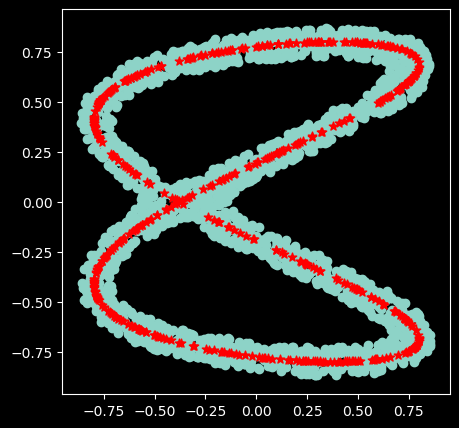

In [39]:
y_new_8shape_series = pd.Series(y_new_8shape.ravel())
indexes_tau8 = y_new_8shape_series[y_new_8shape_series<=tau_8].index
plt.figure(figsize=(5,5))
plt.scatter(X_uniform_8shape[indexes_tau8,0],X_uniform_8shape[indexes_tau8,1])
plt.scatter(X[:,0],X[:,1],marker="*",color="red",s=40)
plt.show()

### Sampling Uniformally from the newly generated points.

##### With replacement.

In [40]:
random_sampled_indexes = np.random.choice(indexes_tau8,800,replace=True)

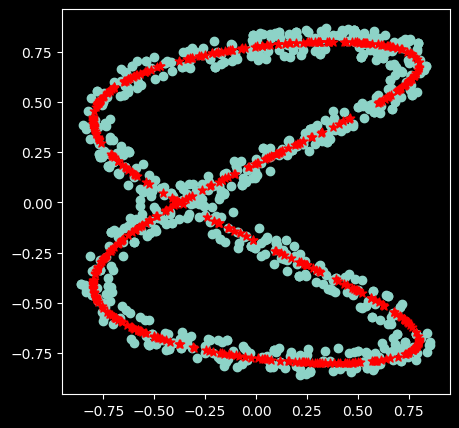

In [41]:
plt.figure(figsize=(5,5))
plt.scatter(X_uniform_8shape[random_sampled_indexes,0],X_uniform_8shape[random_sampled_indexes,1])
plt.scatter(X[:,0],X[:,1],marker="*",color="red",s=40)
plt.show()

##### Without Replacement.

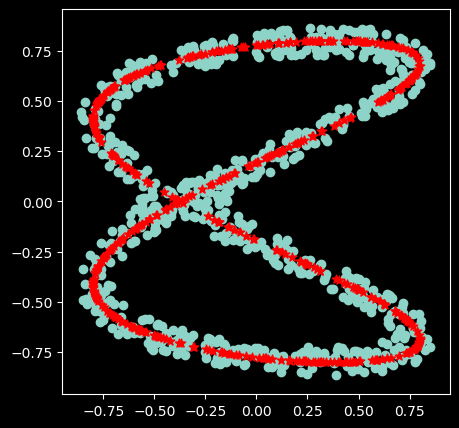

In [42]:
random_sampled_indexes_norep = np.random.choice(indexes_tau8,800,replace=False)
plt.figure(figsize=(5,5))
plt.scatter(X_uniform_8shape[random_sampled_indexes_norep,0],X_uniform_8shape[random_sampled_indexes_norep,1])
plt.scatter(X[:,0],X[:,1],marker="*",color="red",s=40)
plt.show()

##### Advanced Shape.

In [43]:
n_8 = 500
m_8 = 100
tau_8 = 0.2
c=2
t=0
a = np.arange(-1.3,1.3,0.03)
b = np.arange(-1.3,1.3,0.03)
Y = Grid(a,b)

function = abel_2
advanced_shape = sampleLC(3,np.pi/2,2,0,n_8)

# X = sampleLC(2,0.11,1,0.3, n_8)*0.8;

G, mu, s = learnSet(advanced_shape,function,t, c, m_8);
y_advanced = testSet(advanced_shape, G, mu, s,function,t, c, Y);
y_casted_real_advanced = y_advanced.astype(float).reshape(-np.size(a),np.size(b)).T

-----W-testSet 0.21442413330078125 seconds ------
-----y-testSet 0.18096280097961426 seconds ------


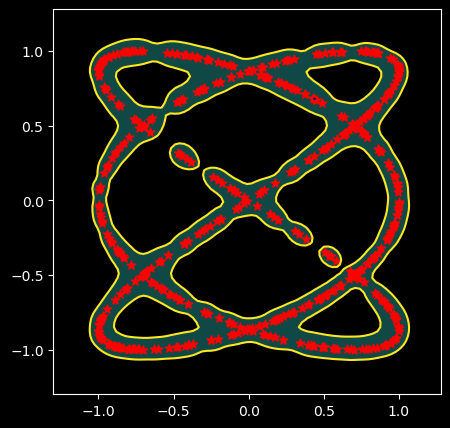

In [44]:
plt.figure(figsize=(5,5))
plt.contourf(a,b,y_casted_real_advanced,levels=[0,tau_8],alpha=0.5)
plt.contour(a,b,y_casted_real_advanced,levels=[0,tau_8])
plt.scatter(advanced_shape[:,0],advanced_shape[:,1],marker="*",color="red",s=40)
plt.show()

In [45]:
from scipy.spatial import cKDTree

### Optimizing the Sampling algorithm
- `euclid_dist` and `np.linalg.norm` give the same timings 
- `np.linalg.norm` can be used to accelerate the algorithm by computing multiple distances and comparing them

In [46]:
def euclid_dist(row1,row2):
    """
    Calculates the euclidean distance.
    """
    return np.sqrt(np.sum((row1-row2)**2))

In [47]:
def euclid_dist_2(row1,row2):
    """
    Calculates the euclidean distance.
    """
    return np.linalg.norm(row1-row2,axis=1)

In [48]:
def value_point(data,index):
    """
    Turns the rows of a dataframe into an array, to apply euclidean distance easily.
    """
    return data.iloc[index].values

In [49]:
def check_euclidean_2(data,new_point_index,index_holder,radius):
    """
    Checks if the new sampled point (new_point_index) respects the distance constraint (radius) 
    against all the other previously sampled points (index_holder) one point at a time.
    
    ##Note## Could be a better way to do this search to make it faster.
    
    """
    if (euclid_dist_2(value_point(data,new_point_index),value_point(data,index_holder)) <= radius).any()==True:
            return index_holder
    index_holder.append(new_point_index)
    return index_holder

In [50]:
def check_euclidean(data,new_point_index,index_holder,radius):
    """
    Checks if the new sampled point (new_point_index) respects the distance constraint (radius) 
    against all the other previously sampled points (index_holder) one point at a time.
    
    ##Note## Could be a better way to do this search to make it faster.
    
    """
    for i in index_holder:
        # calculate the euclidean distance between the reference point and the already set indexes
        # if distance less than preset radius it breaks and refutes the point
        if euclid_dist(value_point(data,new_point_index),value_point(data,i)) <= radius:
            return index_holder
    index_holder.append(new_point_index)
    return index_holder

In [51]:
def get_nearest_neighbors(tree,data,point_index_toquery,radius):
    results_query = tree.query(data.iloc[point_index_toquery],k=100,p=2,distance_upper_bound = radius)
    # query filtered for point indexes to drop, on the distances that are less than infinity
    index_to_drop = results_query[1][results_query[0]<np.inf][1:]
    
    return list(index_to_drop)

In [52]:
def apply_poisson_KDTree(data,n_samples,radius):
    """
    Performs the poisson algorithm.
    """
    # initialize a tree
    mytree = cKDTree(data, leafsize=40)
    # contains a random starting point index
    index_holder = [data.sample(1).index[0]]
    # copy of the data
    data_copy = data.copy()
    # indexes to drop found by kdtree
    index_todrop = get_nearest_neighbors(mytree,data,index_holder[0],radius)
    # drop the row that was sampled from the data
    data_copy.drop(index_holder[0],axis=0,inplace=True)
    # drop the nearest neighbors found by the tree
    data_copy.drop(index_todrop,axis=0,inplace=True)
    
    # while the required N-samples not found keep looping and the data is not empty
    # The condition was softened to avoid having errors in case N data points werent sampled
    # Hard condition : While(len(index_holder) != n_samples):  only
    
    
    while(len(index_holder) < n_samples) and (len(data_copy) != 0):
        # sampling new random point
        new_datapoint = data_copy.sample(1)
        # take the index
        new_point_index = new_datapoint.index[0]
        # variable containing index_holder length 
        len_index_holder = len(index_holder)

        # check if the index is already in the index list
        index_holder = check_euclidean(data,new_point_index,index_holder,radius)

        # drop the new sampled point from the data
        data_copy.drop(new_point_index,axis=0,inplace=True,errors='ignore')
        # if different length, means index holder got a new point added 
        if len(index_holder) != len_index_holder:
            # generate the nearest points of the new datapoint
            index_todrop = get_nearest_neighbors(mytree,data,new_point_index,radius)
            data_copy.drop(index_todrop,axis=0,inplace=True,errors='ignore')
    return index_holder

In [184]:
def apply_poisson_KDTree2(data,n_samples,radius):
    """
    Performs the poisson algorithm.
    """
    # initialize a tree
    mytree = cKDTree(data, leafsize=40)
    # contains a random starting point index
    index_holder = [data.sample(1).index[0]]
    # copy of the data
    data_copy = data.copy()
    # indexes to drop found by kdtree
    index_todrop = get_nearest_neighbors(mytree,data,index_holder[0],radius)
    # drop the row that was sampled from the data
    data_copy.drop(index_holder[0],axis=0,inplace=True,errors='ignore')
    # drop the nearest neighbors found by the tree
    data_copy.drop(index_todrop,axis=0,inplace=True,errors='ignore')
    
    # while the required N-samples not found keep looping and the data is not empty
    # The condition was softened to avoid having errors in case N data points werent sampled
    # Hard condition : While(len(index_holder) != n_samples):  only
    
    
    while(len(index_holder) < n_samples) and (len(data_copy) != 0):
        # sampling new random point
        new_datapoint = data_copy.sample(1)
        # take the index
        new_point_index = new_datapoint.index[0]
        # variable containing index_holder length 
        len_index_holder = len(index_holder)

        # check if the index is already in the index list
        index_holder = check_euclidean_2(data,new_point_index,index_holder,radius)

        # drop the new sampled point from the data
        data_copy.drop(new_point_index,axis=0,inplace=True,errors='ignore')
        # if different length, means index holder got a new point added 
        if len(index_holder) != len_index_holder:
            # generate the nearest points of the new datapoint
            index_todrop = get_nearest_neighbors(mytree,data,new_point_index,radius)
            data_copy.drop(index_todrop,axis=0,inplace=True,errors='ignore')
    return index_holder

In [54]:
def new_points(X,Y,indexes):
    """
    Draws the original data set and the sampled points and highlights them.
    
    """
    plt.figure(figsize=(8,8))


    plt.scatter(X[indexes],Y[indexes],color="yellow",s=100,alpha=0.8,label = "Sampled Points")    
    plt.scatter(X,Y,color="blue",alpha=1,label="Original data",s=1)
    plt.scatter(X[indexes],Y[indexes],color="red",alpha=1,label="Center",s=1)

    plt.legend()
    plt.show()

In [55]:
X_uniform_8shape.shape

(15000, 2)

In [56]:
dataframe = pd.DataFrame(X_uniform_8shape[indexes_tau8,:],columns = ["X","Y"])

In [57]:
start_time = time.time()
poisson_sampling_indexes = apply_poisson_KDTree(dataframe,800,0.05)
print(f"--- {time.time() - start_time} seconds ---")

--- 7.665745258331299 seconds ---


In [58]:
start_time = time.time()
poisson_sampling_indexes2 = apply_poisson_KDTree2(dataframe,800,0.05)
print(f"--- {time.time() - start_time} seconds ---")

--- 0.6648728847503662 seconds ---


In [59]:
poisson_sampling_indexes_01 = apply_poisson_KDTree(dataframe,800,0.1)

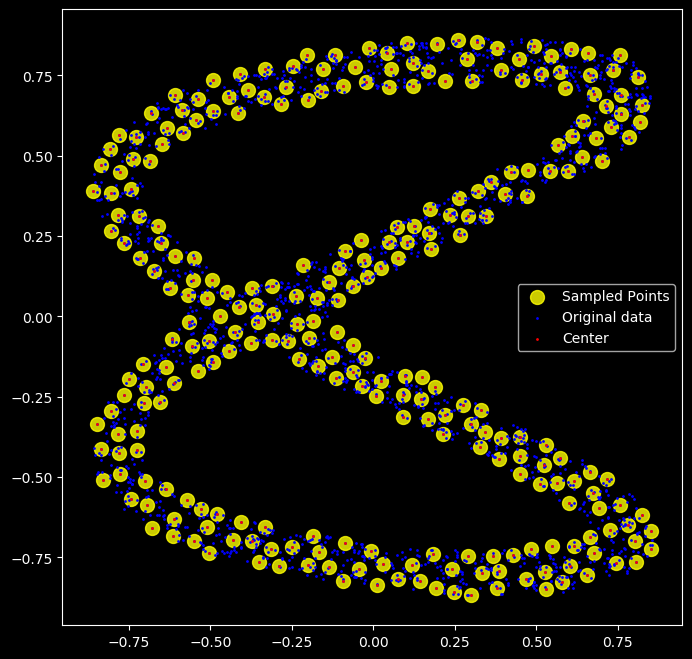

In [60]:
new_points(X_uniform_8shape[indexes_tau8,0],X_uniform_8shape[indexes_tau8,1],poisson_sampling_indexes2)

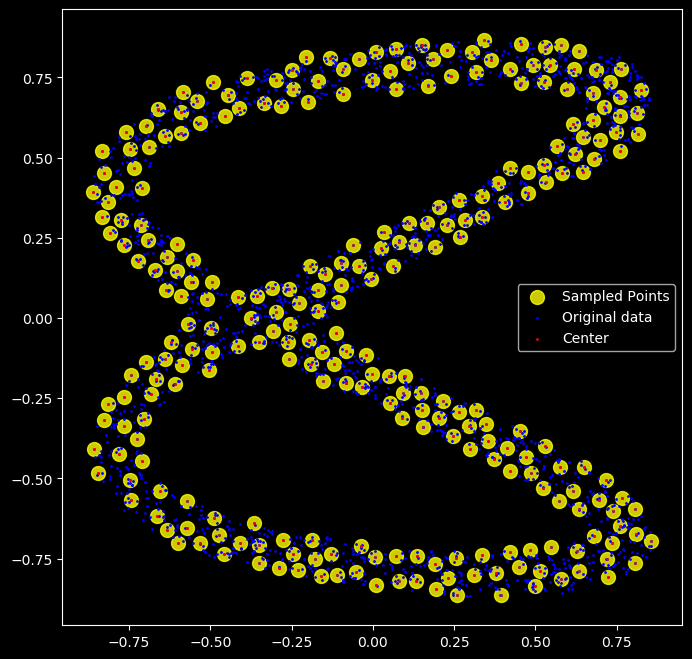

In [61]:
new_points(X_uniform_8shape[indexes_tau8,0],X_uniform_8shape[indexes_tau8,1],poisson_sampling_indexes)

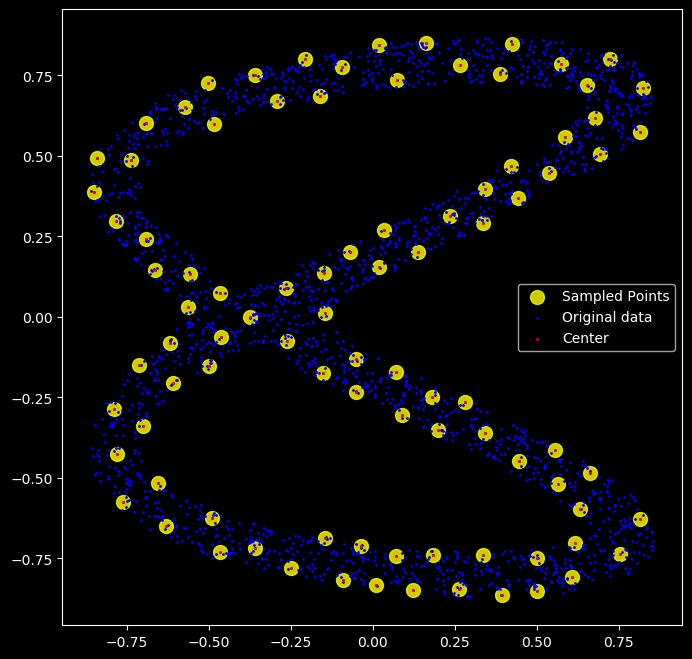

In [62]:
new_points(X_uniform_8shape[indexes_tau8,0],X_uniform_8shape[indexes_tau8,1],poisson_sampling_indexes_01)

# Applying model on toydataset.

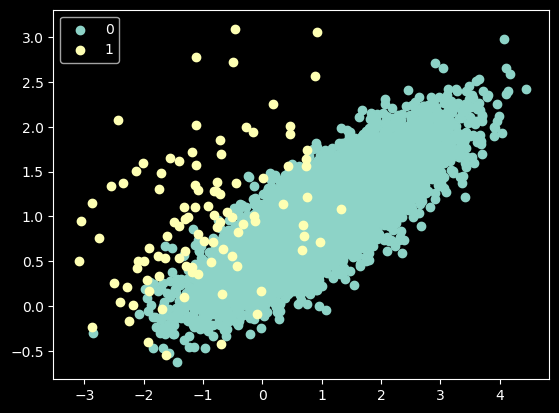

In [230]:
from sklearn.datasets import make_classification
from collections import Counter

X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
    n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
counter = Counter(y)

for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

In [231]:
dataframe_imb = pd.DataFrame(X,columns = ["X1","X2"])

In [232]:
dataframe_imb.head()

,X1,X2
0,0.222014,0.540207
1,1.347439,1.412824
2,0.537238,0.372730
3,2.134462,1.404819
4,2.315827,1.356858


In [233]:
dataframe_imb = pd.concat([dataframe_imb,pd.Series(y)],axis=1)

In [234]:
dataframe_imb.columns = ["X1","X2","Class"]

In [235]:
dataframe_imb.head()

,X1,X2,Class
0,0.222014,0.540207,0
1,1.347439,1.412824,0
2,0.537238,0.372730,0
3,2.134462,1.404819,0
4,2.315827,1.356858,0


In [236]:
majority = dataframe_imb[dataframe_imb.Class==0]
minority = dataframe_imb[dataframe_imb.Class==1]

In [237]:
min(minority["X2"])

-0.5433120260075319

In [98]:
minority_array = minority[["X1","X2"]].to_numpy()

In [238]:
## Testing using the hardcutoff_2 which contains *EIGSH* from scipy. 
m_eig = 20
c=2
t=0
a1 = np.arange(-5,4,0.03)
b1 = np.arange(-5,4,0.03)
Y1 = Grid(a1,b1)

function = abel_2

# testing the time of the learning part
G_toy, mu_toy, s_toy = learnSet2(minority_array,function,t, c, m_eig);

y_distribution = testSet(minority_array, G_toy, mu_toy, s_toy,function,t, c, Y1);

y_distribution_real= y_distribution.astype(float).reshape(-np.size(a1),np.size(b1)).T

-----W-testSet 1.1100704669952393 seconds ------
-----y-testSet 0.38198351860046387 seconds ------


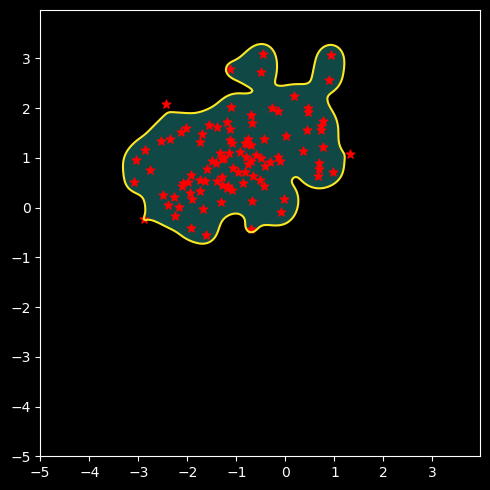

In [244]:
plt.figure(figsize=(5,5))
plt.contourf(a1,b1,y_distribution_real,levels=[0,0.7],alpha=0.5)
plt.contour(a1,b1,y_distribution_real,levels=[0,0.7])
plt.scatter(minority_array[:,0],minority_array[:,1],marker="*",color="red",s=40)
plt.tight_layout()
plt.show()

-----W-testSet 0.14263176918029785 seconds ------
-----y-testSet 0.036893367767333984 seconds ------


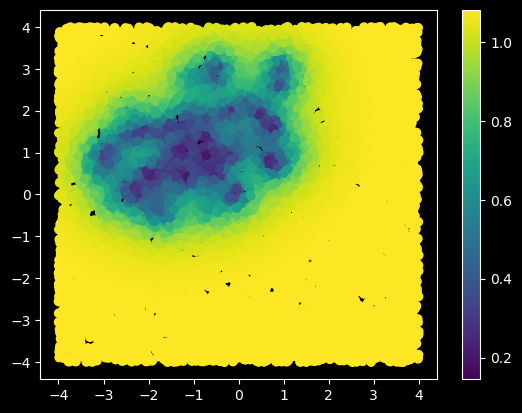

In [245]:
# sample X uniformly 
X_uniform_toy = np.random.uniform(-4,4,(10000,2))
# apply test on new data
y_new_toy = testSet(minority_array,G_toy, mu_toy, s_toy,function,t, c, X_uniform_toy).astype(float)
plt.scatter(X_uniform_toy[:,0],X_uniform_toy[:,1],c=y_new_toy.ravel())
plt.colorbar()
plt.show()

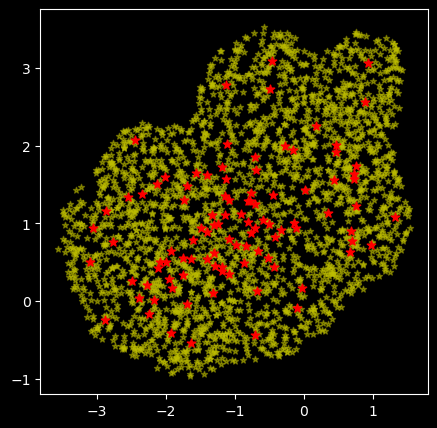

In [246]:
y_new_toy_series = pd.Series(y_new_toy.ravel())
indexes_toy = y_new_toy_series[y_new_toy_series<=0.9].index
plt.figure(figsize=(5,5))
plt.scatter(X_uniform_toy[indexes_toy,0],X_uniform_toy[indexes_toy,1],c="y",marker="*",s=20,alpha=0.5)
plt.scatter(minority_array[:,0],minority_array[:,1],marker="*",color="red",s=40)
plt.show()

In [247]:
dataframe_toy = pd.DataFrame(X_uniform_toy[indexes_toy,:],columns = ["X","Y"])
dataframe_toy.head()

,X,Y
0,-1.950857,-0.427943
1,-0.856622,2.249845
2,-2.304316,0.636513
3,0.604582,2.304002
4,-0.435941,0.218828


In [248]:
poisson_sampling_toy_1 = apply_poisson_KDTree2(dataframe_toy,500,0.15)
len(poisson_sampling_toy_1)

394

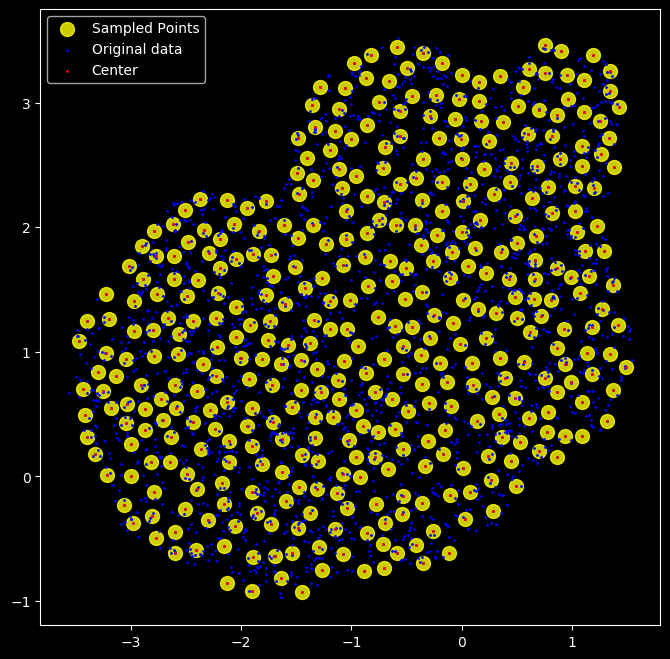

In [249]:
new_points(X_uniform_toy[indexes_toy,0],X_uniform_toy[indexes_toy,1],poisson_sampling_toy_1)

In [250]:
new_data_points = X_uniform_toy[indexes_toy][poisson_sampling_toy_1]

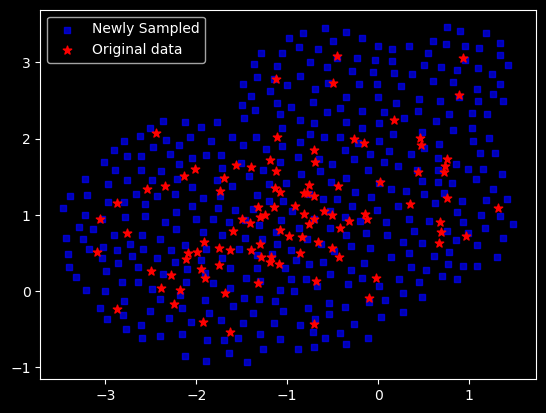

In [251]:
plt.scatter(new_data_points[:,0],new_data_points[:,1], marker= "s",color="blue",s=20,label="Newly Sampled",alpha=0.7)
plt.scatter(minority_array[:,0],minority_array[:,1],marker="*",color="red",s=40,label="Original data")
plt.legend()
plt.show()

In [171]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [173]:
features = dataframe_imb[["X1","X2"]]
labels = dataframe_imb.Class
X_train,X_test,y_train,y_test = train_test_split(features,labels,test_size=0.3,stratify=labels,shuffle=True)
linear_model = LogisticRegression()
linear_model.fit(X_train,y_train)
predictions = linear_model.predict(X_test)

print("---- Classification Report ----\n",classification_report(y_test,predictions))
print("---- CONFUSION MATRIX ----\n",confusion_matrix(y_test,predictions))

---- Classification Report ----
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2970
           1       0.93      0.43      0.59        30

    accuracy                           0.99      3000
   macro avg       0.96      0.72      0.79      3000
weighted avg       0.99      0.99      0.99      3000

---- CONFUSION MATRIX ----
 [[2969    1]
 [  17   13]]


In [272]:
majority.reset_index(drop=True,inplace=True)

In [276]:
majority_indexes = apply_poisson_KDTree2(majority[["X1","X2"]],500,0.1)

In [277]:
len(majority_indexes)

447

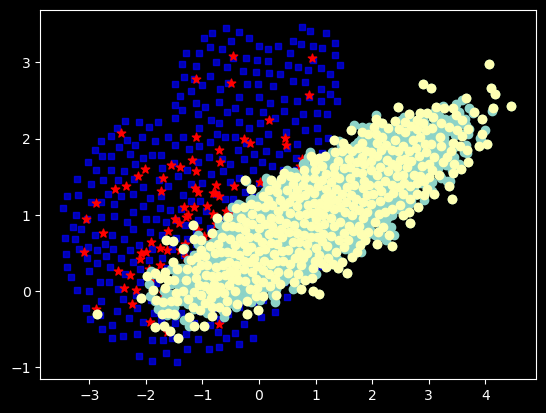

In [279]:
plt.scatter(new_data_points[:,0],new_data_points[:,1], marker= "s",color="blue",s=20,label="Newly Sampled",alpha=0.7)
plt.scatter(minority_array[:,0],minority_array[:,1],marker="*",color="red",s=40,label="Original data")
plt.scatter(majority["X1"],majority["X2"])
plt.scatter(majority.loc[majority_indexes,"X1"],majority.loc[majority_indexes,"X2"])
plt.show()

In [280]:
new_majority_df = majority.iloc[majority_indexes]

In [284]:
len(new_data_points)

394

In [285]:
resampled_minority = pd.DataFrame(np.concatenate([new_data_points,np.ones((394,1))],axis=1),columns=["X1","X2","Class"])

In [286]:
new_dataset = pd.concat([new_majority_df,resampled_minority],axis=0).reset_index(drop=True)

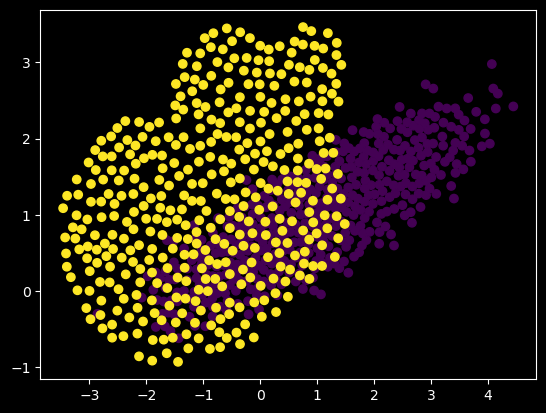

In [287]:
plt.scatter(new_dataset["X1"],new_dataset["X2"],c=new_dataset["Class"])

In [288]:
features = new_dataset[["X1","X2"]]
labels = new_dataset.Class
X_train,X_test,y_train,y_test = train_test_split(features,labels,test_size=0.3,stratify=labels,shuffle=True)
linear_model = LogisticRegression()
linear_model.fit(X_train,y_train)
predictions = linear_model.predict(X_test)

print("---- Classification Report ----\n",classification_report(y_test,predictions))
print("---- CONFUSION MATRIX ----\n",confusion_matrix(y_test,predictions))

---- Classification Report ----
               precision    recall  f1-score   support

         0.0       0.81      0.84      0.82       134
         1.0       0.81      0.77      0.79       119

    accuracy                           0.81       253
   macro avg       0.81      0.80      0.81       253
weighted avg       0.81      0.81      0.81       253

---- CONFUSION MATRIX ----
 [[112  22]
 [ 27  92]]


In [289]:
print("---- Classification Report ----\n",classification_report(y,linear_model.predict(X)))
print("---- CONFUSION MATRIX ----\n",confusion_matrix(y,linear_model.predict(X)))

---- Classification Report ----
               precision    recall  f1-score   support

           0       1.00      0.95      0.97      9900
           1       0.15      0.85      0.25       100

    accuracy                           0.95     10000
   macro avg       0.57      0.90      0.61     10000
weighted avg       0.99      0.95      0.97     10000

---- CONFUSION MATRIX ----
 [[9401  499]
 [  15   85]]


---- Classification Report ----
               precision    recall  f1-score   support

         0.0       0.83      0.86      0.84       136
         1.0       0.83      0.79      0.81       116

    accuracy                           0.83       252
   macro avg       0.83      0.83      0.83       252
weighted avg       0.83      0.83      0.83       252

